The aim of this notebook is to solve the linear advection equation with periodic boundary conditions (example 1.2. in the lecture notes) numerically. We will be solving it using central differences to discretize in space and a third-order Runge-Kutta method to integrate in time.

# Linear advection equation

## Initialize grid and data

We start by discretizing uniformally the domain and initializing the boundary conditions and initial conditions.

In [132]:
using Plots 
using LinearAlgebra
using Einsum
using Pkg
Pkg.update("Einsum")

length = 80
x = range(0,1,length=length)
t = range(0,2, length=length)
delta_x = x[3]-x[2]
# equation coefficient 
a = 1#1/2
print(delta_x)
# Initial conditions
u_0(x) = sin(2*pi*x)
v_0(x) = -sin(2*pi*x)


    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


0.012658227848101266

i_0 (generic function with 1 method)

Analytic solutions for latex comparison

   ## Discretization in space

Let's write down the numerical derivative of $u_0$ on the grid $x$ using a central difference scheme. Note that this can be represented by a matrix $D$. The numerical derivative $u_{x,0}$ can then be given by the inner product $D.u_0$.

In [155]:
a = randn(2,2)
b = randn(2,2)

c = zeros(2,2)
@einsum c[i,j] = a[i,k] * b[k,j] # matrix multiplication
#initialize a matrix with zeros
D = zeros(length, length)

# Set the first diagonal above the main diagonal of the matrix to 1 and the one below to -1
for i in range(1,length-1)
    D[i,i+1] = 1/2
    if i >= 2
        D[i,i-1] = -1/2
    end
end 
# Changing elements corresponding to boudnary conditions
D[1,1] = -1
D[1,2] = 1
D[length, length] = 1
D[length, length-1] = -1
# expanding to get a matrix corresponding to derivatives of two functions
#D = [D zeros(length, length); zeros(length, length) D]
D_new = zeros(length,length,2)
D_new[:,:,1] = D
D_new[:,:,2] = D
D = D_new
delta_x = x[2]-x[1]
D /= delta_x
# Mass matrix 
M = Diagonal(ones(length))
M[1, 1] = 1/2; M[length,length] = 1/2
M_new = zeros(length,length,2)
M_new[:,:,1] = M; M_new[:,:,2] = M 
M = M_new
M *= delta_x
M_inv = zeros(length,length,2)
M_inv[:,:,1] = inv(M[:,:,1]); M_inv[:,:,2] = inv(M[:,:,2]) 
print(M_inv)
# checking whether everything is correct
T1 = zeros(length, length, 2); T2 = zeros(length, length, 2)
@einsum T1[i,j,k] = M[i,j,k]*D[i,j,k]
D_perm = permutedims(D, (2,1,3))
@einsum T2[i,j,k] = M[i,j,k]*D_perm[j,i,k]
# t_L and t_R operators 
t_L = zeros(length,2); t_L[1,1] = 1; t_L[1,2] = 1
t_R = zeros(length,2); t_R[length,1] = 1; t_R[length,2] = 1

[158.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0

 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

1

(80, 2)

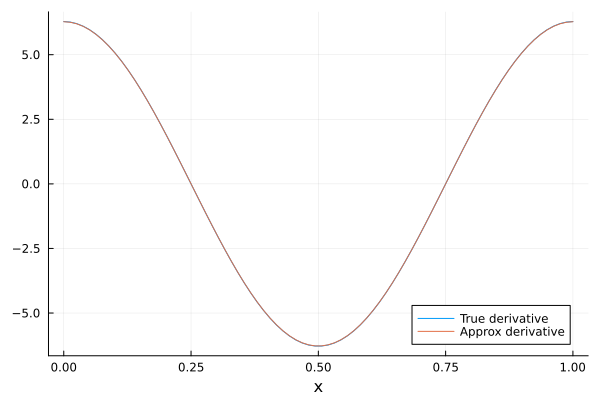

In [161]:
z_0 = zeros(length,2)
z_0[:,1] = u_0.(x); z_0[:,2] = v_0.(x) 
# test derivative of initial data 
dz_0_approx = zeros(length,2)
@einsum dz_0_approx[j,k] = D[j,i,k]*z_0[i,k]
print(size(dz_0_approx))
dz_true = zeros(length,2)
dz_true[:,1] = 2*pi*cos.(2*pi*x); dz_true[:,2] = -2*pi*cos.(2*pi*x)

plot(x, dz_true[:,1], xlabel="x", label="True derivative")
plot!(x, dz_0_approx[:,1], xlabel="x", label="Approx derivative")

## Time propoagator 

We will now implement a function to numerically compute integration over time. It is a third-order Runge-Kutta method (see lecture notes). 

In [256]:

function propagator_block(u,t)
    BC = [u[1,2];u[length,1]] - [u[1,1];u[length,2]]
    BC = abs.(BC)
    M_inv_new = zeros(length, 2)
    @einsum M_inv_new[j,k] = M_inv[i,j,k]*t_L[i,k]
    vec1 = zeros(length,2)
    BC = M_inv_new * BC
    du_approx = zeros(length,2)
    @einsum du_approx[j,k] = D[j,i,k]*u[i,k]
    return +du_approx - vec1
end 

propagator_block (generic function with 2 methods)

In [266]:
# Set the time step size 
delta_t = 0.01
function propagator(n_steps, u_0)
    t = 0 + delta_t*n_steps
    for i in range(1, n_steps)
        y_1 = u_0
        y_2 = u_0 .- delta_t.*(propagator_block(y_1,t))
        y_3 = u_0 .- delta_t*0.25.*(propagator_block(y_1,t).+ propagator_block(y_2,t))
        u_0 = u_0 .- delta_t*(1/6).*(propagator_block(y_1,t).+propagator_block(y_2,t)) .- (2*delta_t/3).*(propagator_block(y_3,t))
        #u_0 = u_0 + delta_t.*propagator_block(u_0,t)  
        t += delta_t 
    end 
    return u_0
end 


propagator (generic function with 1 method)

In [267]:
# Determine transient region for specific time
steps = 20
t = steps*delta_t

0.2

-1.2573015855892962

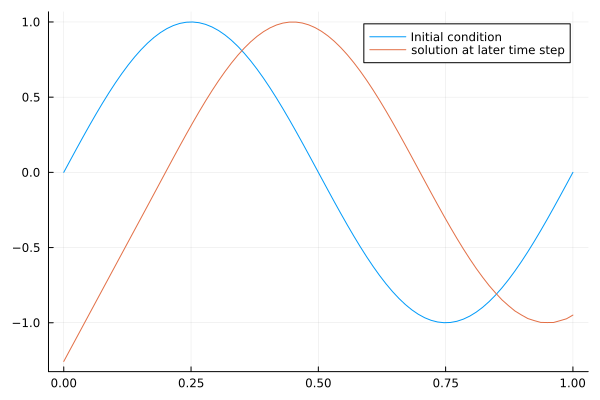

In [268]:

result = propagator(steps, z_0)
print(result[1,1]-z_0[1,1])
#plot(x,u.(x, 5*delta_t))
#analit_sol = analytic_solution.(x_test,steps*delta_t)
plot(x,z_0[:,1], label="Initial condition")
plot!(x, result[:,1], label="solution at later time step")

In [423]:
# computing L^2 error
one = ones(size(x_transient)[1])
error = sqrt(one'*M*(analit_sol.-result).^2)

0.06792706414132173